In [2]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Load the dataset
df = pd.read_csv('data_smartac.csv')
print(df.head())

   Suhu Luar Kebiasaan Penghuni   Kondisi Perangkat Waktu Hari  \
0         30    Sering di Rumah        Dioperasikan      Siang   
1         25    Jarang di Rumah  Tidak Dioperasikan      Siang   
2         18    Sering di Rumah  Tidak Dioperasikan      Malam   
3         28    Jarang di Rumah        Dioperasikan      Siang   
4         22    Sering di Rumah        Dioperasikan      Malam   

  Keputusan Energi (AC/Pemanas)  
0            Menurunkan Suhu AC  
1             Matikan Perangkat  
2              Nyalakan Pemanas  
3            Menurunkan Suhu AC  
4              Nyalakan Pemanas  


In [12]:
# Create the new insight column: 'Aktivitas Rumah' (Home Activity Index)
def calculate_aktivitas_rumah(row):
    kebiasaan = row['Kebiasaan Penghuni']
    kondisi = row['Kondisi Perangkat']
    
# 1: Low Use, 4: High Use
    if kebiasaan == 'Jarang di Rumah' and kondisi == 'Tidak Dioperasikan':
        return 1
    elif kebiasaan == 'Jarang di Rumah' and kondisi == 'Dioperasikan':
        return 2
    elif kebiasaan == 'Sering di Rumah' and kondisi == 'Tidak Dioperasikan':
        return 3
    elif kebiasaan == 'Sering di Rumah' and kondisi == 'Dioperasikan':
        return 4
    else:
        return np.nan

df['Aktivitas Rumah'] = df.apply(calculate_aktivitas_rumah, axis=1)
df_cleaned = df.dropna()

# Determine ranges for the universal sets from the cleaned data
min_temp = df_cleaned['Suhu Luar'].min()
max_temp = df_cleaned['Suhu Luar'].max()
min_aktivitas = df_cleaned['Aktivitas Rumah'].min()
max_aktivitas = df_cleaned['Aktivitas Rumah'].max()

In [13]:
# Define the universal variables (Antecedents = Input, Consequent = Output)
# Suhu Luar range: min_temp to max_temp
temp_universe = np.arange(min_temp, max_temp + 1, 1)
suhu_luar = ctrl.Antecedent(temp_universe, 'suhu_luar')

# Aktivitas Rumah range: 1 to 4
aktivitas_universe = np.arange(min_aktivitas, max_aktivitas + 0.1, 0.1)
aktivitas_rumah = ctrl.Antecedent(aktivitas_universe, 'aktivitas_rumah')

# Aksi AC Score range: 0 to 10
action_universe = np.arange(0, 11, 1)
aksi_ac = ctrl.Consequent(action_universe, 'aksi_ac')


# Define Membership Functions (MFs)
# Suhu Luar MFs
suhu_luar['dingin'] = fuzz.trapmf(suhu_luar.universe, [min_temp, min_temp, 20, 24])
suhu_luar['sedang'] = fuzz.trimf(suhu_luar.universe, [22, 26, 30])
suhu_luar['panas'] = fuzz.trapmf(suhu_luar.universe, [28, 32, max_temp, max_temp])

# Aktivitas Rumah MFs
aktivitas_rumah['rendah'] = fuzz.trapmf(aktivitas_rumah.universe, [1, 1, 2, 3])
aktivitas_rumah['tinggi'] = fuzz.trapmf(aktivitas_rumah.universe, [2, 3, 4, 4])

# Aksi AC MFs (Output)
aksi_ac['pemanasan'] = fuzz.trapmf(aksi_ac.universe, [0, 0, 2, 4])
aksi_ac['stabil'] = fuzz.trimf(aksi_ac.universe, [3, 5, 7])
aksi_ac['pendinginan'] = fuzz.trapmf(aksi_ac.universe, [6, 8, 10, 10])

# Visualize MFs (Optional, used for checking design)
# suhu_luar.view()
# aktivitas_rumah.view()
# aksi_ac.view()

# Construct Fuzzy Logic Rules
rule1 = ctrl.Rule(suhu_luar['dingin'] & aktivitas_rumah['rendah'], aksi_ac['pemanasan'])
rule2 = ctrl.Rule(suhu_luar['dingin'] & aktivitas_rumah['tinggi'], aksi_ac['stabil'])
rule3 = ctrl.Rule(suhu_luar['sedang'] & aktivitas_rumah['rendah'], aksi_ac['stabil'])
rule4 = ctrl.Rule(suhu_luar['sedang'] & aktivitas_rumah['tinggi'], aksi_ac['stabil'])
rule5 = ctrl.Rule(suhu_luar['panas'] & aktivitas_rumah['rendah'], aksi_ac['stabil'])
rule6 = ctrl.Rule(suhu_luar['panas'] & aktivitas_rumah['tinggi'], aksi_ac['pendinginan'])

# Build the Control System
aksi_ac_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])

In [14]:
# Function to compute AC Action Score
def compute_aksi_ac_score(row, control_system):
    aksi_ac_simulation = ctrl.ControlSystemSimulation(control_system)
    
    try:
        # Clip inputs to universes before setting
        temp_value = np.clip(row['Suhu Luar'], temp_universe.min(), temp_universe.max())
        aktivitas_value = np.clip(row['Aktivitas Rumah'], aktivitas_universe.min(), aktivitas_universe.max())
        
        aksi_ac_simulation.input['suhu_luar'] = temp_value
        aksi_ac_simulation.input['aktivitas_rumah'] = aktivitas_value

        aksi_ac_simulation.compute()
        return aksi_ac_simulation.output['aksi_ac']

    except Exception:
        # Handle cases where computation fails (e.g., empty fuzzy set)
        return np.nan

# Apply the fuzzy logic model to the dataset
df_cleaned['Aksi AC Score'] = df_cleaned.apply(
    lambda row: compute_aksi_ac_score(row, aksi_ac_ctrl), axis=1
)

In [15]:
# Classification of AC Action
def classify_ac_action(score):
    if score >= 6.5:
        return 'Pendinginan (Cooling)'
    elif score >= 3.5:
        return 'Stabil (Stable/No Action)'
    else:
        return 'Pemanasan (Heating)'

df_cleaned['Aksi AC Category'] = df_cleaned['Aksi AC Score'].apply(classify_ac_action)

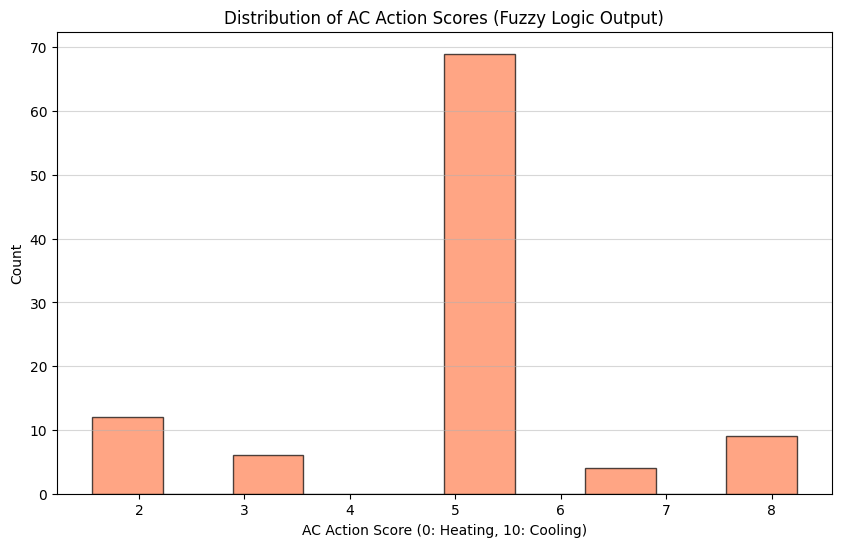

In [16]:
# Plot the distribution of AC Action Scores
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['Aksi AC Score'].dropna(), bins=10, color='coral', edgecolor='black', alpha=0.7)
plt.title('Distribution of AC Action Scores (Fuzzy Logic Output)')
plt.xlabel('AC Action Score (0: Heating, 10: Cooling)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.5)
plt.show() 

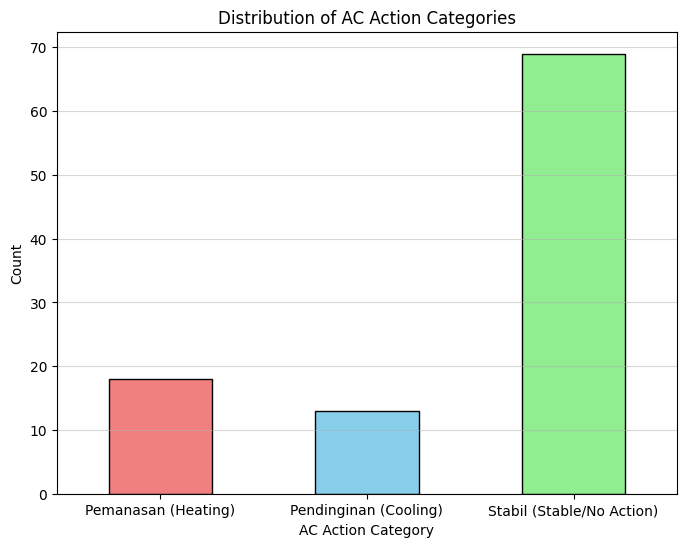

In [19]:
# Plot the distribution of AC Action Categories
category_counts = df_cleaned['Aksi AC Category'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color=['lightcoral', 'skyblue', 'lightgreen'], edgecolor='black', rot=0)
plt.title('Distribution of AC Action Categories')
plt.xlabel('AC Action Category')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.5)
plt.show() 

In [18]:
# Display final results
print("\nData Head with Fuzzy Results:")
print(df_cleaned[['Suhu Luar', 'Aktivitas Rumah', 'Aksi AC Score', 'Aksi AC Category']].head())

# Save the resulting dataframe to a CSV
df_cleaned.to_csv('data_smartac_with_fuzzy_results.csv', index=False)


Data Head with Fuzzy Results:
   Suhu Luar  Aktivitas Rumah  Aksi AC Score           Aksi AC Category
0         30                4            8.0      Pendinginan (Cooling)
1         25                1            5.0  Stabil (Stable/No Action)
2         18                3            5.0  Stabil (Stable/No Action)
3         28                2            5.0  Stabil (Stable/No Action)
4         22                4            5.0  Stabil (Stable/No Action)
